In [37]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1]
print(case)

/home/lena/Promotion/neurolib/GUI/current/gui/data/01120
01120


### Bistability

In [39]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [40]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [41]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [42]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [43]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [44]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [45]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]

if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [46]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [47]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


In [60]:
# get initial parameters and target states

i_stepsize = 1
limit = 65
start_index = 60
i_range = range(start_index, limit,i_stepsize)
i_range_0 = range(start_index, limit,i_stepsize)
i_range_1 = range(start_index, limit,i_stepsize)

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  60 0.5500000000000003 0.6250000000000003
-------  61 0.5750000000000002 0.6250000000000003
-------  62 0.4250000000000001 0.6500000000000004
-------  63 0.4500000000000001 0.6500000000000004
-------  64 0.47500000000000014 0.6500000000000004


In [61]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  60 0.5500000000000003 0.6250000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  148385.25117022273
Gradient descend method:  None
RUN  0 , total integrated cost =  148385.25117022273
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  61 0.5750000000000002 0.6250000000000003
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  173480.81674342768
Gradient descend method:  None
RUN  0 , total integrated cost =  173480.81674342768
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  62 0.4250000000000001 0.6500000000000004
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  34493.011682862874
Gradient descend method:  None
RUN  0 , total integrated cost =  34493.011682862874
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  63 0.4500000000000001 0.6500000000

In [62]:
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    if not type(bestControl_init[i]) == type(None):
        continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  60 0.5500000000000003 0.6250000000000003
-------  61 0.5750000000000002 0.6250000000000003
set cost params:  1.0 10.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  173480.81674342768
Gradient descend method:  None
RUN  1 , total integrated cost =  594.5096121606321
RUN  2 , total integrated cost =  300.86326698692136
RUN  3 , total integrated cost =  285.0823410049055
RUN  4 , total integrated cost =  271.1217872254204
RUN  5 , total integrated cost =  267.77157880577977
RUN  6 , total integrated cost =  254.14556210550123
RUN  7 , total integrated cost =  244.65523954476592
RUN  8 , total integrated cost =  236.42174772159848
RUN  9 , total integrated cost =  233.27761466408384
RUN  10 , total integrated cost =  227.14539914837286
RUN  11 , total integrated cost =  223.95285970028172
RUN  12 , total integrated cost =  219.9460053779278
RUN  13 , total integrated cost =  216.020865728701
RUN  14 , total integrated cost =  212.3626211200571
RUN  15

--------- 60


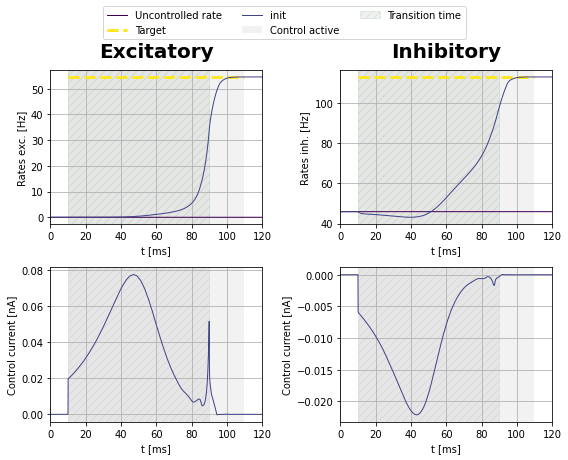

--------- 61


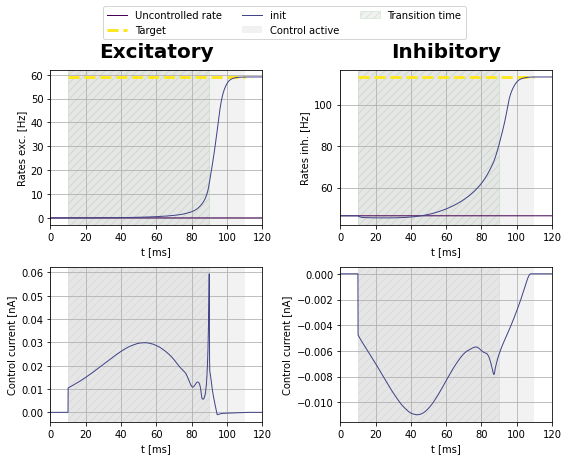

--------- 62


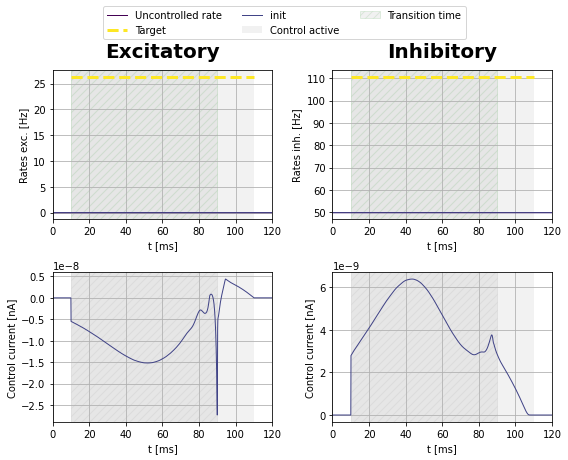

--------- 63


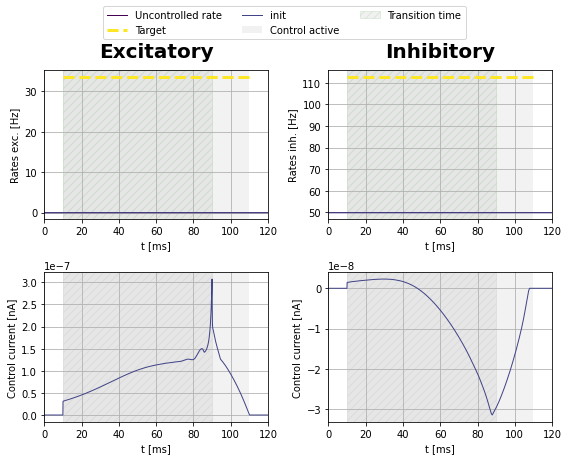

--------- 64


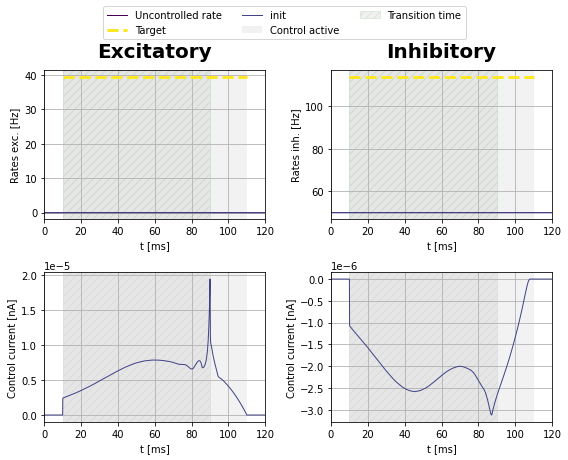

In [71]:
#plot initial guesses
for i in i_range:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()


In [72]:
found_solution = []
no_solution = []
factor_iteration = 1.
already_tried = [ [] for _ in range(len(exc)) ]

for k in range(len(i_range)**2):
    print('------------------------------------------------------------')
    print('--------------------', k)
    print('------------------------------------------------------------')
        
    print("found solution: ", found_solution)
    print("no solution: ", no_solution)
    
    if len(i_range) == len(found_solution) + len(no_solution):
        print("found solution for all parameters")
        break


    for i in i_range:
        print("------- ", i, exc[i], inh[i])     

        if np.abs(np.mean(bestState_init[i][0,0,-10:]) - target[i][0,0,-1]) < 0.2 * np.abs(
            np.mean(bestState_init[i][0,0,-10:]) - bestState_init[i][0,0,0]) and np.abs(
            np.mean(bestState_init[i][0,1,-10:]) - target[i][0,1,-1]) < 0.2 * np.abs(
            np.mean(bestState_init[i][0,1,-10:]) - bestState_init[i][0,1,0]) and np.amax(
            bestState_init[i][0,0,:]) < target[i][0,0,-1] + 1. and np.amax(
            bestState_init[i][0,1,:]) < target[i][0,1,-1] + 1.:
            # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
            #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
            if i not in found_solution:
                print("found solution for ", i)
                found_solution.append(i)
            if i in no_solution:
                no_solution.pop(no_solution.index(i))
            continue

        if len(found_solution) == 0:
            continue
            
        closest_ = getclosest(i, found_solution, exc, inh, already_tried[i])
        print("closest index ", closest_)

        weight_ = 10
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
            
        if i != 0 and closest_ != -1:
            control0 = 2. * bestControl_init[closest_][:,:,n_pre-1:-n_post+1]
            if closest_ not in already_tried[i]:
                already_tried[i].append(closest_)
                        
        if closest_ == -1:
            print("all options tried already")
            if i not in no_solution:
                no_solution.append(i)
                continue

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(100 * factor_iteration)

        weights_init[i] = cost.getParams()
        
        print("precision vars = ", prec_vars)

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        j = 1
        while cost_init[i][-j] == 0.:
            j += 1

        weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(500 * factor_iteration)

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)

------------------------------------------------------------
-------------------- 0
------------------------------------------------------------
found solution:  []
no solution:  []
-------  60 0.5500000000000003 0.6250000000000003
found solution for  60
-------  61 0.5750000000000002 0.6250000000000003
found solution for  61
-------  62 0.4250000000000001 0.6500000000000004
[60, 61] []
closest index  60
set cost params:  1.0 10.0 0.0
precision vars =  [0]
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  34586.134356488954
Gradient descend method:  None
RUN  1 , total integrated cost =  34493.03440861057
RUN  2 , total integrated cost =  34493.0116884099
RUN  3 , total integrated cost =  34493.01168286423
RUN  4 , total integrated cost =  34493.011682862874
RUN  5 , total integrated cost =  34493.011682862874
Control only changes marginally.
RUN  5 , total integrated cost =  34493.011682862874
Improved over  5  iterations in  0.18073420703876764  seconds by  0.26

RUN  11 , total integrated cost =  653.9691896663688
RUN  12 , total integrated cost =  636.5582354704887
RUN  13 , total integrated cost =  618.9026378592594
RUN  14 , total integrated cost =  603.756524440904
RUN  15 , total integrated cost =  589.1722051676539
RUN  16 , total integrated cost =  573.4413634864127
RUN  17 , total integrated cost =  558.3764643078954
RUN  18 , total integrated cost =  545.0928936136174
RUN  19 , total integrated cost =  531.9214050510942
RUN  20 , total integrated cost =  518.4568944426403
RUN  30 , total integrated cost =  404.91879576866404
RUN  40 , total integrated cost =  309.2935651350721
RUN  50 , total integrated cost =  298.4399150319519
RUN  60 , total integrated cost =  296.6191693796389
RUN  70 , total integrated cost =  295.77333524962455
Control only changes marginally.
RUN  78 , total integrated cost =  295.7733275319154
Improved over  78  iterations in  2.531773386988789  seconds by  91.95323269977695  percent.
weight =  1166.1975057281

In [73]:
factor_iteration = 20
full_converge = False
conv_init = [[False]*2] * len(exc)

for i in range(len(conv_init)):
    if i not in i_range:
        conv_init[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print("------------------------------------------------")
    print('-------------------------', counter)
    
    if counter > 20:
        break
        
    print(conv_init[::i_stepsize])
    full_converge = True
    
    for conv in conv_init[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_init[i] == [True, True]:
            continue
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        j = 1
        while cost_init[i][-j] == 0.:
            j += 1
                       
        weight_ = (factor_we * weights_init[i][1] * cost_uncontrolled[i] / cost_init[i][-j]
                   + factor_ws * weights_init[i][2] * cost_uncontrolled[i] / cost_init[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)
            
        if j == cost_init[i].shape[0]-1:
            print("converged for ", i)
            if conv_init[i][0]:
                conv_init[i] = [True, True]
            else:
                conv_init[i] = [True, False]
            continue
    
        print("no convergence")
            
    counter += 1

------------------------------------------------
------------------------- 0
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [T

interpolate adjoint :  True True True
RUN  0 , total integrated cost =  34463.7750816232
Gradient descend method:  None
RUN  1 , total integrated cost =  34463.775081538195
RUN  2 , total integrated cost =  34463.775081538086
RUN  3 , total integrated cost =  34463.77508153808
RUN  4 , total integrated cost =  34463.77508153808
Control only changes marginally.
RUN  4 , total integrated cost =  34463.77508153808
Improved over  4  iterations in  0.34788266400573775  seconds by  2.469846549502108e-10  percent.
no convergence
-------  63 0.4500000000000001 0.6500000000000004
weight =  2672.915559538787
set cost params:  1.0 2672.915559538787 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  56095.549942813785
Gradient descend method:  None
RUN  1 , total integrated cost =  56095.54994281372
RUN  2 , total integrated cost =  56095.54994281369
RUN  3 , total integrated cost =  56095.54994281369
Control only changes marginally.
RUN  3 , total integrated cost =  56095

RUN  1 , total integrated cost =  34463.7800789208
RUN  2 , total integrated cost =  34463.78007892078
RUN  3 , total integrated cost =  34463.78007892078
Control only changes marginally.
RUN  3 , total integrated cost =  34463.78007892078
Improved over  3  iterations in  0.2791518559679389  seconds by  3.268496584496461e-13  percent.
no convergence
-------  63 0.4500000000000001 0.6500000000000004
weight =  2672.9155719165387
set cost params:  1.0 2672.9155719165387 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  56095.55020233174
Gradient descend method:  None
RUN  1 , total integrated cost =  56095.550202331644
RUN  2 , total integrated cost =  56095.55020233162
RUN  3 , total integrated cost =  56095.55020233162
Control only changes marginally.
RUN  3 , total integrated cost =  56095.55020233162
Improved over  3  iterations in  0.34443636698415503  seconds by  2.1316282072803006e-13  percent.
no convergence
-------  64 0.47500000000000014 0.6500000000000

RUN  1 , total integrated cost =  34463.78007898759
RUN  2 , total integrated cost =  34463.78007898759
Control only changes marginally.
RUN  2 , total integrated cost =  34463.78007898759
Improved over  2  iterations in  0.2690613270387985  seconds by  1.4210854715202004e-13  percent.
no convergence
-------  63 0.4500000000000001 0.6500000000000004
weight =  2672.9155719165487
set cost params:  1.0 2672.9155719165487 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  56095.55020233184
Gradient descend method:  None
RUN  1 , total integrated cost =  56095.55020233184
Control only changes marginally.
RUN  1 , total integrated cost =  56095.55020233184
Improved over  1  iterations in  0.14470143400831148  seconds by  0.0  percent.
no convergence
-------  64 0.47500000000000014 0.6500000000000004
weight =  4966.529043723634
set cost params:  1.0 4966.529043723634 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  77638.3851301029
Gradient 

RUN  1 , total integrated cost =  77638.38513010273
Control only changes marginally.
RUN  1 , total integrated cost =  77638.38513010273
Improved over  1  iterations in  0.16294172900961712  seconds by  0.0  percent.
converged for  64
------------------------------------------------
------------------------- 8
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [

In [66]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [74]:
delete = [61, 62, 63, 64]
for i in delete:
    bestControl_0[i] = None

In [75]:
factor_iteration = 20
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 20:
        break
    
    print(conv_0[::i_stepsize])
    full_converge = True
    
    for conv in conv_0[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True

RUN  1 , total integrated cost =  77638.38513010272
Control only changes marginally.
RUN  1 , total integrated cost =  77638.38513010272
Improved over  1  iterations in  0.10621063702274114  seconds by  0.0  percent.
converged for  64
--------------- 2
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tru

In [68]:
"""
for i in i_range_0:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
"""

'\nfor i in i_range_0:\n    \n    aln.params.ext_exc_current = exc[i] * 5.\n    aln.params.ext_inh_current = inh[i] * 5.\n\n    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],\n        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,\n        dur_pre, dur_post, initVars[i], target[i], \'\', filename_ = \'\', transition_time_ = trans_time,\n        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)\n'

In [69]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

file found


In [76]:
factor_iteration = 20
conv_1 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 20:
        break
    
    print(conv_1[::i_stepsize])
    full_converge = True
    
    for conv in conv_1[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_1[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1

--------------- 0
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True

RUN  13 , total integrated cost =  15.857171052907448
RUN  14 , total integrated cost =  15.857171032814687
RUN  15 , total integrated cost =  15.857171026446622
RUN  16 , total integrated cost =  15.857171024522664
RUN  17 , total integrated cost =  15.857171023970011
RUN  18 , total integrated cost =  15.857171023792542
RUN  19 , total integrated cost =  15.857171023734871
RUN  20 , total integrated cost =  15.8571710237153
Control only changes marginally.
RUN  28 , total integrated cost =  15.857171023706135
Improved over  28  iterations in  1.250094786984846  seconds by  95.62521076139205  percent.
no convergence
--------------- 1
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True,

RUN  1 , total integrated cost =  15.857171023706135
Control only changes marginally.
RUN  1 , total integrated cost =  15.857171023706135
Improved over  1  iterations in  0.09890954301226884  seconds by  0.0  percent.
converged for  64
--------------- 3
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [T